In [6]:
%matplotlib inline

In [7]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [27]:
def loadImages(location):
    imageset = torchvision.datasets.ImageFolder(root = location, 
                                                transform=transforms.ToTensor())
    imageloader = torch.utils.data.DataLoader(imageset, batch_size=32, shuffle=True,
                                            num_workers=8)
    return imageloader
    


def imshow(img):
    npimg = img.numpy()
    trans = np.transpose(npimg, (1, 2, 0))
    plt.imshow(trans)
    plt.show()

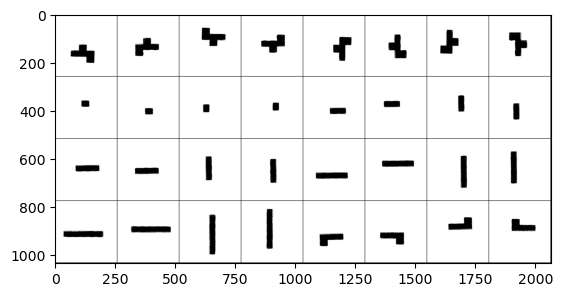

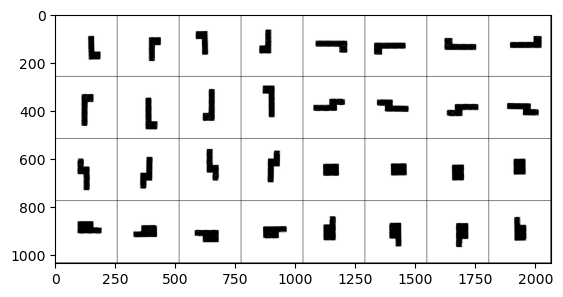

In [28]:
images = loadImages("TrainingImages/ProcessedResized")
imageiter = iter(images)
print(imageiter)
image, labels = next(imageiter)
image2, labels2 = next(imageiter)
imshow(torchvision.utils.make_grid(image))
imshow(torchvision.utils.make_grid(image2))

In [39]:
class ClassiferModel(nn.Module):
    def __init__(self, inputs=28*28, outputs=10):
        super(ClassiferModel, self).__init__()
        # Default Layers
        self.conv1 = nn.Conv2d(3, 16, 3) # 16 3x3 Filters
        self.conv2 = nn.Conv2d(16, 32, 3) # 32 3x3 Filters
        self.conv3 = nn.Conv2d(32, 64, 3) # 64 3x3 Filters
        self.conv4 = nn.Conv2d(64, 128, 3) # 128 3x3 Filter
        self.conv5 = nn.Conv2d(128, 256, 3) # 256 3x3 Filters
        self.conv6 = nn.Conv2d(256, 512, 3) # 512 3x3 Filter
        
        # ImageNet Layers
        self.imageNetConv = nn.Conv2d(1, 1024, 3) # 1024 3x3 Filters
        self.imageNetFull = nn.Linear(1024, 1000) # Fully Connected Network of 1024 to 1000 


    def forward(self, x):
        print(x.shape)
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        print(x.shape)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        print(x.shape)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        print(x.shape)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        print(x.shape)
        x = self.conv5(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        print(x.shape)
        x = self.conv6(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        print(x.shape)
        return x


In [10]:
import torch.optim as optim

def train(net, dataloader, epochs=1, lr=0.01, momentum=0.9, decay=0.0, verbose=1):
  net.to(device)
  losses = []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
  for epoch in range(epochs):
    sum_loss = 0.0
    for i, batch in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch[0].to(device), batch[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # autograd magic, computes all the partial derivatives
        optimizer.step() # takes a step in gradient direction

        # print statistics
        losses.append(loss.item())
        sum_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, sum_loss / 100))
            sum_loss = 0.0
  return losses

In [11]:
from torchvision import models

resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


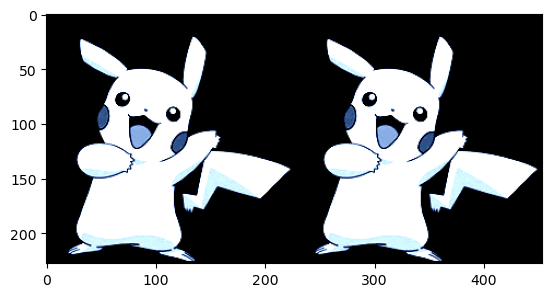

In [16]:
weights = models.ResNet50_Weights.DEFAULT
preprocess = weights.transforms()
print(preprocess)
newimage = preprocess(image)
imshow(torchvision.utils.make_grid(newimage))